In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder  # ✅ 新增

# 加载数据
df = pd.read_csv('housing.csv')

print("\n缺失值情况:")
print(df.isnull().sum())


encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df['ocean_proximity_encoded'] = encoder.fit_transform(df[['ocean_proximity']])

# 查看编码
print("\n分类编码映射:")
for idx, cat in enumerate(encoder.categories_[0]):
    print(f"  {cat} → {idx}")

# ========== ✅ 改动2：分离特征（删除原始分类列）==========
X = df.drop(['median_house_value', 'ocean_proximity'], axis=1)
y = df['median_house_value']

print(f"\n特征列: {list(X.columns)}")
print(f"特征数量: {X.shape[1]}")

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ========== 找到分类特征索引 ==========
categorical_feature_index = list(X.columns).index('ocean_proximity_encoded')
print(f"分类特征索引: {categorical_feature_index}")

# ========== 添加 categorical_features 参数 ==========
hgb_model = HistGradientBoostingRegressor(
    categorical_features=[categorical_feature_index],  # ✅ 关键参数
    max_depth=12,
    max_iter=310,
    learning_rate=0.07,
    min_samples_leaf=20,
    random_state=42,
    l2_regularization=0.9,
)

print("\n开始训练...")
hgb_model.fit(X_train, y_train)
print(f"✅ 训练完成")

# 交叉验证
print("\n进行交叉验证...")
cv_scores = cross_val_score(
    hgb_model, X_train, y_train, 
    cv=5, 
    verbose=1,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

cv_rmse = np.sqrt(-cv_scores)
print(f"交叉验证 RMSE: {cv_rmse.mean():,.2f} (+/- {cv_rmse.std():,.2f})")

# 预测和评估
y_pred = hgb_model.predict(X_test)

print("\n" + "=" * 50)
print("模型性能评估 (原生分类处理)")
print("=" * 50)
print(f'RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred)):,.2f}')
print(f'MAE: ${mean_absolute_error(y_test, y_pred):,.2f}')
print(f'R² Score: {r2_score(y_test, y_pred):.4f}')

# ========== 安全获取特征重要性 ==========
print("\n" + "=" * 50)
print("特征重要性")
print("=" * 50)

try:
    if hasattr(hgb_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': hgb_model.feature_importances_
        }).sort_values('importance', ascending=False)
        print(feature_importance.to_string(index=False))
    else:
        raise AttributeError("No feature_importances_ attribute")
        
except AttributeError:
    print("⚠️ 使用 Permutation Importance 替代...")
    from sklearn.inspection import permutation_importance
    
    result = permutation_importance(
        hgb_model, X_test, y_test, 
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': result.importances_mean,
        'std': result.importances_std
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.to_string(index=False))


缺失值情况:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

分类编码映射:
  <1H OCEAN → 0
  INLAND → 1
  ISLAND → 2
  NEAR BAY → 3
  NEAR OCEAN → 4

特征列: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity_encoded']
特征数量: 9
分类特征索引: 8

开始训练...
✅ 训练完成

进行交叉验证...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


交叉验证 RMSE: 47,341.24 (+/- 725.71)

模型性能评估 (原生分类处理)
RMSE: $46,497.09
MAE: $31,121.05
R² Score: 0.8350

特征重要性
⚠️ 使用 Permutation Importance 替代...
                feature  importance      std
              longitude    0.580176 0.007508
          median_income    0.519485 0.014219
               latitude    0.465631 0.011003
ocean_proximity_encoded    0.127156 0.004911
             population    0.125121 0.003624
         total_bedrooms    0.071201 0.003074
            total_rooms    0.055179 0.002046
     housing_median_age    0.035391 0.001617
             households    0.009223 0.000958


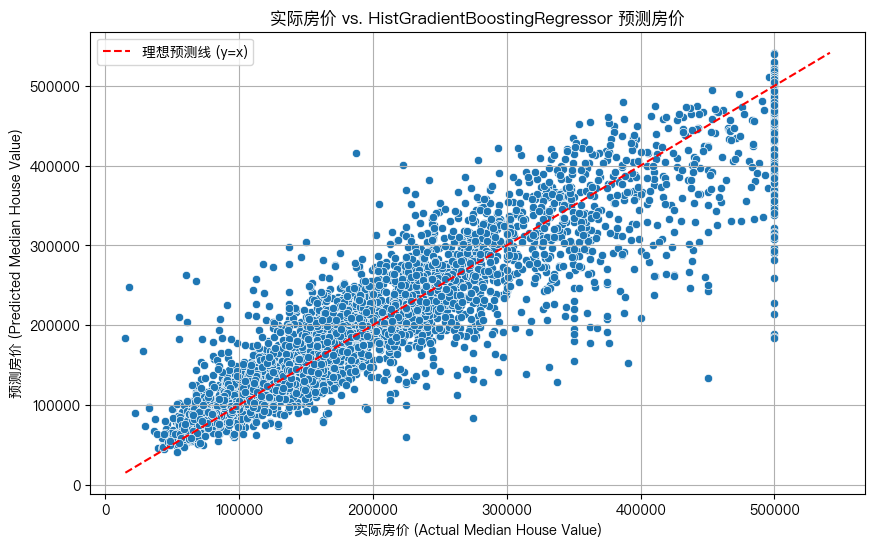

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn import tree
matplotlib.rcParams['font.sans-serif'] = "PingFang HK"

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)

# 添加 y=x 参考线
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_test.min()) # 使用 y_test 的最小值来确定范围
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='理想预测线 (y=x)')

plt.title('实际房价 vs. HistGradientBoostingRegressor 预测房价')
plt.xlabel('实际房价 (Actual Median House Value)')
plt.ylabel('预测房价 (Predicted Median House Value)')
plt.legend()
plt.grid(True)
plt.show()

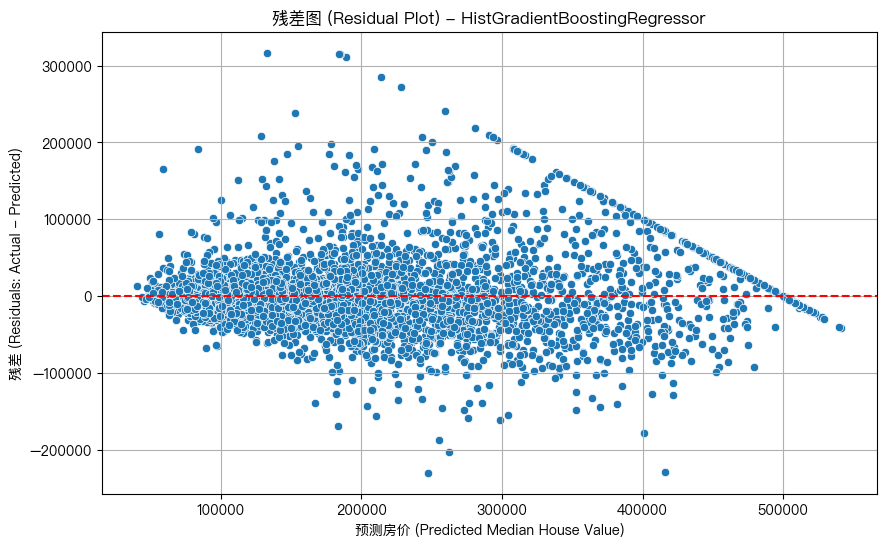

In [23]:
# 计算残差
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
# 绘制残差 vs 预测值
sns.scatterplot(x=y_pred, y=residuals) 

# 添加零线
plt.axhline(y=0, color='r', linestyle='--')

plt.title('残差图 (Residual Plot) - HistGradientBoostingRegressor')
plt.xlabel('预测房价 (Predicted Median House Value)')
plt.ylabel('残差 (Residuals: Actual - Predicted)')
plt.grid(True)
plt.show()

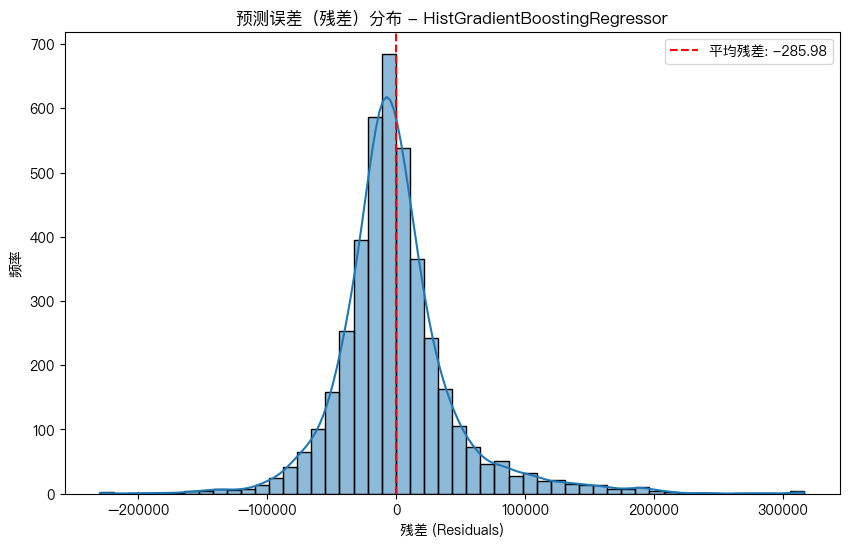

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)

# 添加平均残差线
plt.axvline(residuals.mean(), color='r', linestyle='--', label=f'平均残差: {residuals.mean():,.2f}')

plt.title('预测误差（残差）分布 - HistGradientBoostingRegressor')
plt.xlabel('残差 (Residuals)')
plt.ylabel('频率')
plt.legend()
plt.show()

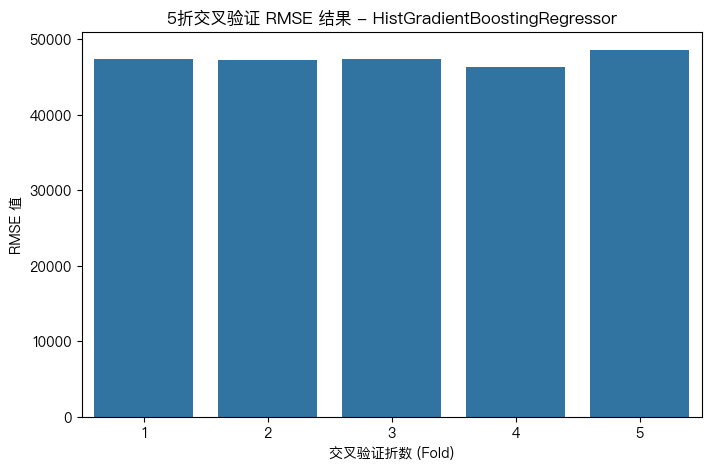

In [25]:

plt.figure(figsize=(8, 5))
sns.barplot(x=list(range(1, len(cv_rmse) + 1)), y=cv_rmse)

plt.title('5折交叉验证 RMSE 结果 - HistGradientBoostingRegressor')
plt.xlabel('交叉验证折数 (Fold)')
plt.ylabel('RMSE 值')
plt.show()

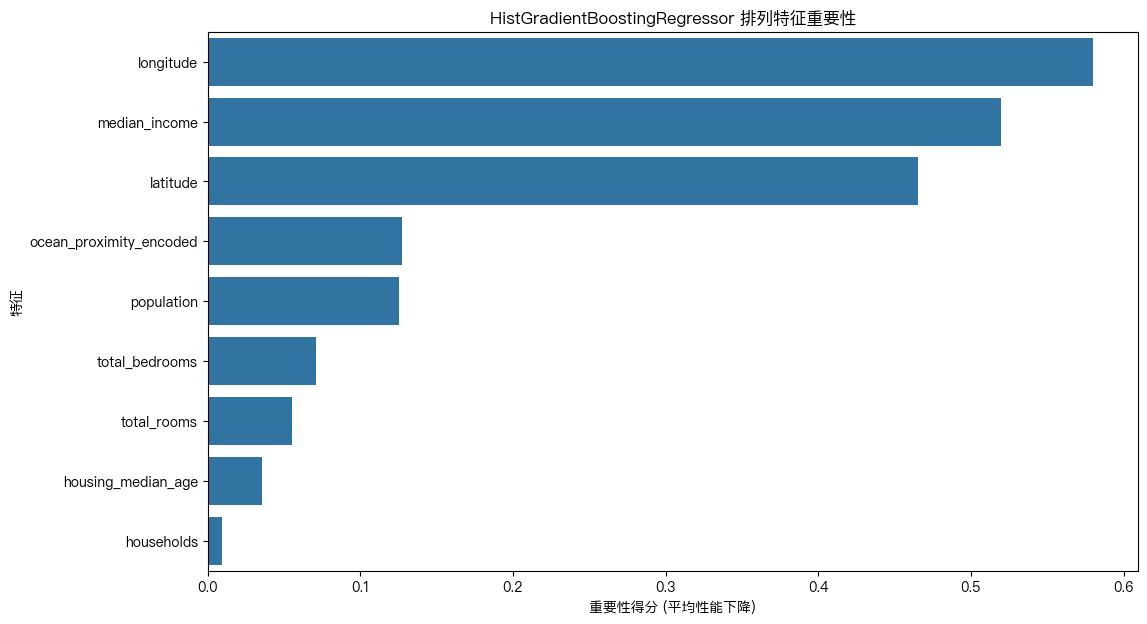

[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.3s


In [26]:
from sklearn.inspection import permutation_importance

# 计算排列重要性
# 使用测试集进行评估，以获得更真实的泛化性能
r = permutation_importance(
    hgb_model, 
    X_test, 
    y_test, 
    n_repeats=10, # 重复次数
    random_state=42, 
    n_jobs=-1
)

# 提取结果并排序
sorted_idx = r.importances_mean.argsort()[::-1]
importances = pd.Series(r.importances_mean[sorted_idx], index=X.columns[sorted_idx])

plt.figure(figsize=(12, 7))
sns.barplot(x=importances.values, y=importances.index)

plt.title('HistGradientBoostingRegressor 排列特征重要性')
plt.xlabel('重要性得分 (平均性能下降)')
plt.ylabel('特征')
plt.show()

# 模型超参数调优

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy.stats import uniform, randint
import numpy as np
import pandas as pd


# 定义参数分布
param_distributions = {
    # 学习率：在 0.01 到 0.2 之间均匀采样
    'learning_rate': uniform(loc=0.01, scale=0.19), 

    # 树的数量：在 50 到 300 之间随机整数采样
    'max_iter': randint(50, 300), 

    # 最大深度：在 5 到 20 之间随机整数采样
    'max_depth': randint(5, 20), 

    # 叶子节点最小样本数：在 10 到 50 之间随机整数采样
    'min_samples_leaf': randint(10, 50),

    # L2 正则化：在 0.0 到 1.0 之间均匀采样
    'l2_regularization': uniform(loc=0.0, scale=1.0)
}

In [14]:
# 实例化模型
hgb = HistGradientBoostingRegressor(random_state=42)

# 实例化随机搜索对象
# n_iter: 尝试的参数组合数量
# cv: 交叉验证折数
# scoring: 评估指标（使用负均方误差，因为 RandomizedSearchCV 默认最大化分数）
# verbose: 输出详细程度
# n_jobs: 使用的 CPU 核心数
random_search = RandomizedSearchCV(
    estimator=hgb,
    param_distributions=param_distributions,
    n_iter=50,  # 尝试 50 种不同的参数组合
    cv=5,       # 5 折交叉验证
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)


print("开始超参数随机搜索...")
random_search.fit(X_train, y_train)

# 获取最佳参数和最佳分数
best_params = random_search.best_params_
best_score = np.sqrt(-random_search.best_score_) # 转换回 RMSE

print("\n" + "=" * 50)
print("随机搜索最佳结果")
print("=" * 50)
print(f"最佳参数: {best_params}")
print(f"最佳交叉验证 RMSE: {best_score:,.2f}")

# 使用找到的最佳参数创建最终模型
final_hgb_model = HistGradientBoostingRegressor(**best_params, random_state=42)
final_hgb_model.fit(X_train, y_train)

# 在测试集上评估
y_pred_tuned = final_hgb_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
final_r2 = r2_score(y_test, y_pred_tuned)

print("\n" + "=" * 50)
print("调优后模型在测试集上的性能")
print("=" * 50)
print(f'测试集 RMSE: ${final_rmse:,.2f}')
print(f'测试集 R² Score: {final_r2:.4f}')

开始超参数随机搜索...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

随机搜索最佳结果
最佳参数: {'l2_regularization': np.float64(0.9429097039125192), 'learning_rate': np.float64(0.07140855708394349), 'max_depth': 12, 'max_iter': 282, 'min_samples_leaf': 21}
最佳交叉验证 RMSE: 47,370.58

调优后模型在测试集上的性能
测试集 RMSE: $46,992.37
测试集 R² Score: 0.8315


## 在随机搜索结果下进行更加精细的网格搜索

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np


# 定义基于随机搜索结果的精细参数网格
param_grid = {
    'learning_rate': [0.05, 0.07, 0.10],
    'max_iter': [250, 280, 310],
    'max_depth': [12, 15, 17],
    'min_samples_leaf': [20, 25, 35],
    'l2_regularization': [0.7, 0.8, 0.9]
}

# 计算总共需要拟合的模型数量
total_fits = (
    len(param_grid['learning_rate']) * 
    len(param_grid['max_iter']) * 
    len(param_grid['max_depth']) * 
    len(param_grid['min_samples_leaf']) * 
    len(param_grid['l2_regularization']) * 
    5 # 5折交叉验证
)

print(f"网格搜索将尝试 {len(param_grid['learning_rate'])} * {len(param_grid['max_iter'])} * {len(param_grid['max_depth'])} * {len(param_grid['min_samples_leaf'])} * {len(param_grid['l2_regularization'])} = {total_fits // 5} 种参数组合。")
print(f"总共需要进行 {total_fits} 次模型拟合。")


# 实例化模型
hgb = HistGradientBoostingRegressor(random_state=42)

# 实例化网格搜索对象
grid_search = GridSearchCV(
    estimator=hgb,
    param_grid=param_grid,
    cv=5,       # 5 折交叉验证
    scoring='neg_mean_squared_error', # 评估指标
    verbose=2,  # 输出详细程度
    n_jobs=-1   # 使用所有 CPU 核心
)

网格搜索将尝试 3 * 3 * 3 * 3 * 3 = 243 种参数组合。
总共需要进行 1215 次模型拟合。


In [17]:
print("\n开始超参数网格搜索...")
# 假设 X_train 和 y_train 已经加载并预处理
grid_search.fit(X_train, y_train) 

# 假设 fit 已经完成
best_params_grid = grid_search.best_params_
best_score_grid = np.sqrt(-grid_search.best_score_)

print("\n" + "=" * 50)
print("网格搜索最佳结果")
print("=" * 50)
print(f"最佳参数: {best_params_grid}")
print(f"最佳交叉验证 RMSE: {best_score_grid:,.2f}")


开始超参数网格搜索...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

网格搜索最佳结果
最佳参数: {'l2_regularization': 0.9, 'learning_rate': 0.07, 'max_depth': 12, 'max_iter': 310, 'min_samples_leaf': 20}
最佳交叉验证 RMSE: 47,271.30
